In [1]:
# following micrograd note, build the exact neuron, with two inputs, one output, in Pytorch API 
# A modern deep learning neural network libary, is sth to use in production, 

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _operands=(), _operator='', label = ''):
        self.data = data
        self._prev = set(_operands) # object involed with self in an operation, __operands are objects participated in the operation
        self._op = _operator
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None 
        # _backwars is called to calculate parents derivatives 
            
    def __repr__(self):
        return f"Value(data={self.data})" # provide a nicer looking of the BOX class, what's inside
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # isinstance(other, Value) returns True if other is already a Value object
        # If True: other stays as-is
        # If False: other gets converted to Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            return;
        out._backward = _backward
        return out
    
    # o = x^n, do/dx = n*x^(n-1) 
    def __pow__(self, n):
        assert isinstance(n, (int, float)), "only supporting int/float for now"
        x = self.data
        out = Value(x**n, (self, ), f'**{n}')

        def _backward():
            self.grad += n*(x**(n-1)) * out.grad
        
        out._backward = _backward
        
        return out

    # def __pow__(self, other):
    #     assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    #     out = Value(self.data**other, (self,), f'**{other}')
    
    #     def _backward():
    #         self.grad += other * (self.data ** (other - 1)) * out.grad
    #     out._backward = _backward
    
    #     return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self*(-1)

    def __sub__(self, other):
        return self + (-other)
        
    def __rmul__(self, other):
        return self * other
    # Regular multiplication calls __mul__
    # my_object * 5        # calls my_object.__mul__(5)
    
    # Reverse multiplication calls __rmul__  
    # 5 * my_object        # calls my_object.__rmul__(5)


    # self/other, rewrite to self**(-1), 1/self
    def __truediv__(self, other):
        return self*other**(-1)

    # o = e^x, do/dx = e^x 
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.grad * out.data 
            # math.exp(x) d(out)/d(self) = e^(self) = out.data
            # Chain rule: self.grad += out.grad * (derivative of exp)
        out._backward = _backward
        return out
            
    def backward(self):
        topo = [];
        visited = set();
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                # topo.append(v) must happens inside of v not in visited, if visited, do not append agian!!!!, pay attention to indentation
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value( 6.8813735870195432, label='b')  
#change to 8, will see tanh really impact on n.data
#change to 6.7, not much impact
#change to 6.8813735870195432, ensure when we start backpropergation, no creazy numbers 

# calculation steps 
w1x1 = w1*x1; w1x1.label = 'w1x1'
w2x2 = w2*x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label ='w1x1 + w2x2'

# final simple raw neuron without activation
n = w1x1w2x2 + b; n.label = 'n'
# --------
# update, o.tanh()
# o = math.exp(2*n - 1)/math.exp(2*n + 1)
# to:
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/ (e + 1)
# --------b
o.label = 'o'

o.backward()

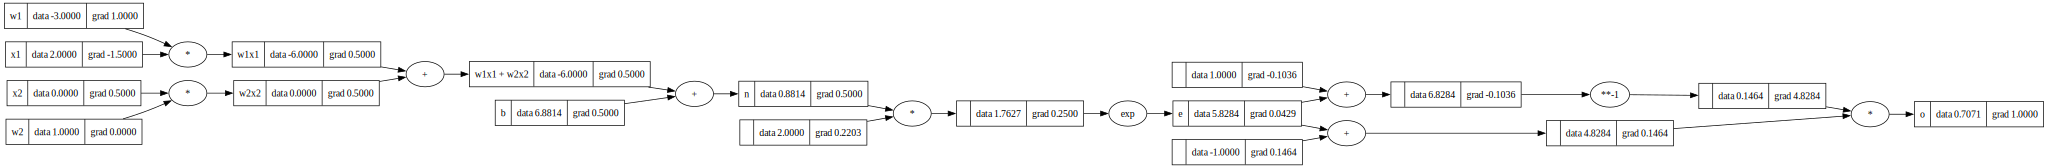

In [6]:
draw_dot(o)

In [ ]:
# do the same thing in pytorch 

In [8]:
import torch

In [17]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
# .item takes one single tensor as element, takes that element out of the tensor
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [11]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

In [12]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [16]:
x1 = torch.Tensor([2.0]).double()  
x1

tensor([2.], dtype=torch.float64)

In [18]:
o
# o is an tensor object, it got backward function just as we implemented in micrograd

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [19]:
o.item()

0.7071066904050358

In [20]:
o.data.item()

0.7071066904050358

In [21]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [22]:
x2.grad.item()

0.5000001283844369

In [ ]:
# neural networks are just a specific class of mathmatical expressions 
